In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from qiskit import execute, Aer
from circuits import RepetitionCode
from fitters import GraphDecoder, lookuptable_decoding, postselection_decoding

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_meas,p_gate):

    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_model
noise_model = get_noise(0.04,0.04)

In [3]:
d = 8
T = 2
# code = RepetitionCode(d,T)
empty_code = RepetitionCode(d,T)

In [4]:
empty_code.qubit_registers

{'code_qubit', 'link_qubit'}

In [5]:
empty_code.code_qubit

QuantumRegister(8, 'code_qubit')

In [10]:
def get_syndrome(code,noise_model,shots=1014):
    circuits = code.get_circuit_list()
    job = execute( circuits, Aer.get_backend('qasm_simulator'),noise_model=noise_model, shots=shots )
    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(log)

    return raw_results
raw_results = get_syndrome(empty_code, noise_model, shots=4096)

{0: 0.0830078125, 1: 0.1103515625, 2: 0.10986328125, 3: 0.10498046875, 4: 0.10888671875, 5: 0.1044921875, 6: 0.110107421875, 7: 0.07275390625, 8: 0.1923828125, 9: 0.1943359375, 10: 0.196044921875, 11: 0.19921875, 12: 0.18505859375, 13: 0.193603515625, 14: 0.1806640625, 15: 0.081298828125, 16: 0.08447265625, 17: 0.088134765625, 18: 0.098388671875, 19: 0.099609375, 20: 0.091552734375, 21: 0.098876953125}
{0: 0.923583984375, 1: 0.887451171875, 2: 0.888671875, 3: 0.889404296875, 4: 0.893310546875, 5: 0.896728515625, 6: 0.89501953125, 7: 0.92626953125, 8: 0.1875, 9: 0.19287109375, 10: 0.197509765625, 11: 0.19140625, 12: 0.205078125, 13: 0.187255859375, 14: 0.171630859375, 15: 0.0791015625, 16: 0.092529296875, 17: 0.093994140625, 18: 0.093017578125, 19: 0.095947265625, 20: 0.0947265625, 21: 0.083984375}


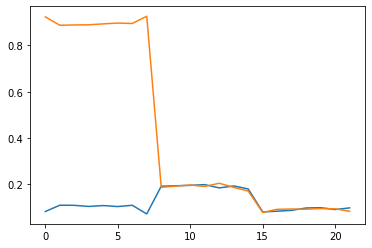

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def plot_qubit_probs(raw_res_dict):
    # get "probability of 1" for logical 0 
    for log in ["0", "1"]:
        all_occurances = list(raw_res_dict[log].keys())
        occurance_counts = list(raw_res_dict[log].values())
        ar = [list(x.replace(" ", "")) for x in all_occurances]
        dat = pd.DataFrame(ar)
        dat["counts"] = pd.Series(occurance_counts)
        qbitnum_prob_map = {}
        for i in range(len(dat.columns) - 1):
            qbitnum_prob_map[i] = (dat.loc[(dat[i]=="1")]["counts"]).sum()/trial_shots
        print(qbitnum_prob_map)
        plt.plot(list(qbitnum_prob_map.values()))
    plt.show()
    # get "probability of 1" for logical 1

plot_qubit_probs(raw_results)

In [12]:
def get_logical_prob():
    raw_results = get_syndrome(empty_code,noise_model=noise_model,shots=8192)
    results = empty_code.process_results(raw_results)

    dec = GraphDecoder(empty_code)

    logical_prob_match = dec.get_logical_prob(results)
    logical_prob_lookup = lookuptable_decoding(results,results)
    logical_prob_post = postselection_decoding(results)

#     for log in ['0','1']:
#         print('d =',d,',log =',log)
#         print('logical error probability for matching      =',logical_prob_match[log])
#         print('logical error probability for lookup table  =',logical_prob_lookup[log])
#         print('logical error probability for postselection =',logical_prob_post[log])
#         print('')
#     print('')
    return logical_prob_match['0'], logical_prob_match['1']

get_logical_prob()

(0.0013427734375, 0.00146484375)